## Step #1: Install PyC

In [5]:
%%capture
#!pip install torch
!pip install https://github.com/pyc-team/pytorch_concepts/releases/download/v0.0.10/pytorch_concepts-0.0.10.tar.gz

## Step #2: Load traffic scenario

In [1]:
# Making seeds fixed for determinism

import numpy as np
import torch

seed = 42
print(f"Setting random seeds to {seed}")
torch.manual_seed(seed)
np.random.seed(seed)

Setting random seeds to 42


In [2]:
from torch_concepts.data.datasets.traffic import TrafficLights
# In practice, we need datasets that are significantly larger, but we will
# not use those for this example as we want to focus on the main ideas rather
# than on performane
n_samples = 500

# Loading dataset
dataset = TrafficLights(
    n_samples=n_samples,
    possible_starting_directions=['west'],
    resize_final_image=0.05,
    selected_concepts=[
        'green light on selected lane',
        'car in intersection',
        'ambulance seen',
        'ambulance approaching perpendicular to selected car',
    ],
    split='train',
)
concept_names, task_names = dataset.concept_names, dataset.task_names
n_concepts = len(concept_names)

# Example of scenario
print(f"Input shape: {dataset.input_shape}")
print(f"Using {n_concepts} concepts with semantics: {concept_names}")
print(f"Task has {len(task_names)} downstream tasks: {task_names}")

/home/user_cril/meher/CRIL/CBM/TrafficLights/traffic-env/lib/python3.10/site-packages/torch_concepts/nn/__init__.py:18: FutureWarning: The 'torch_concepts.nn.mid' module contains experimental APIs that are unstable and subject to change without notice. If you are using these classes intentionally, be aware that breaking changes may occur in future releases. Consider using the high-level API (torch_concepts.nn.high) for stable interfaces.
  from .modules.mid.base.model import BaseConstructor
100%|██████████| 100/100 [00:07<00:00, 12.90it/s]

Input shape: (3, 64, 64)
Using 4 concepts with semantics: [np.str_('green light on selected lane'), np.str_('car in intersection'), np.str_('ambulance seen'), np.str_('ambulance approaching perpendicular to selected car')]
Task has 1 downstream tasks: ['continue']


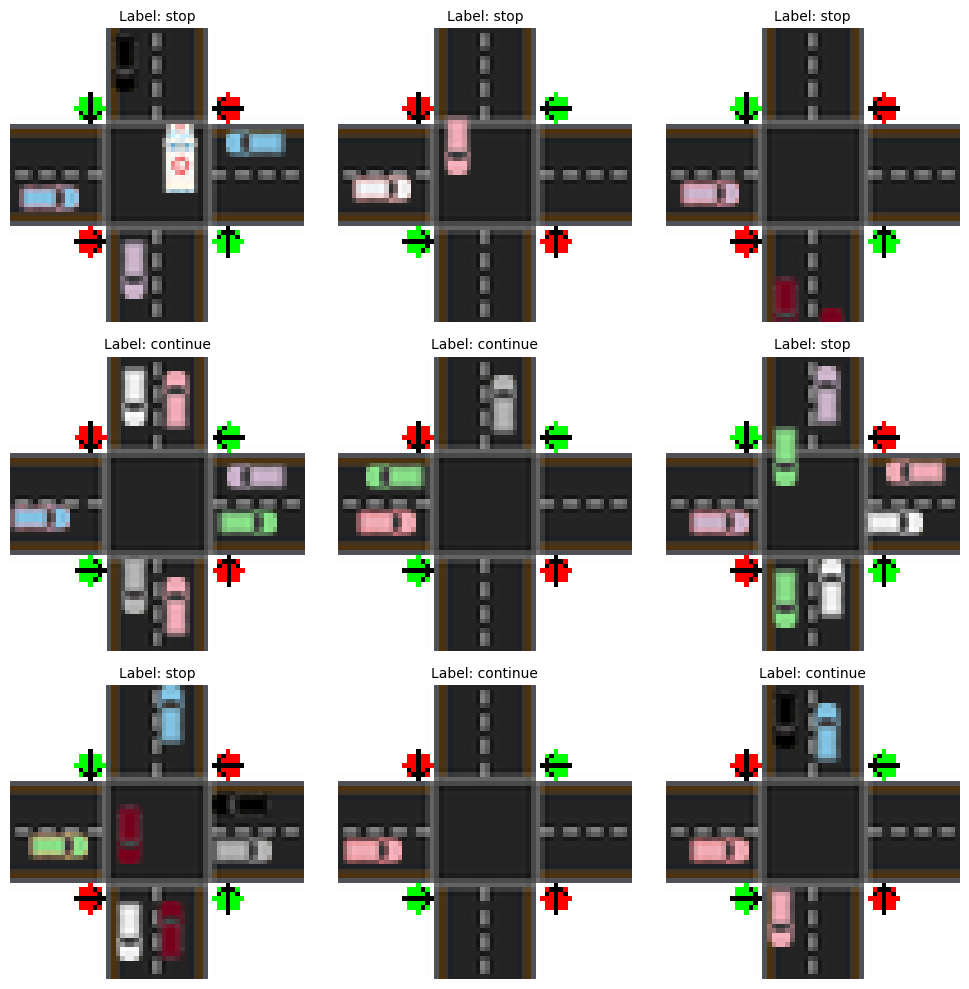

In [3]:
import matplotlib.pyplot as plt
import random

# Select a random sample of indices for the grid
grid_size = (3, 3)
indices = random.sample(range(len(dataset)), grid_size[0] * grid_size[1])
sampled_images = [dataset[i][0] for i in indices]
sampled_labels = [dataset[i][1] for i in indices]
label_names = ['stop', 'continue']

# Plot images in a grid
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
axes = axes.flatten()  # Flatten to easily iterate over axes if needed

for i, ax in enumerate(axes):
    ax.imshow(
        sampled_images[i].detach().cpu().numpy().transpose(1, 2, 0),
        cmap=None,
    )
    ax.set_title(
        f"Label: {label_names[int(sampled_labels[i])]}",
        fontsize=10,
    )
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## Step #3: Define the CBM

In [4]:
import torch

latent_dims = 32

# The encoder extracts a low-dimensional representation of the input
encoder = torch.nn.Sequential(
    # A 3x3 convolution with 4 output channels
    torch.nn.Conv2d(3, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),

    # A 3x3 convolution with 4 output channels with a batch norm
    torch.nn.Conv2d(4, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm2d(4),

    # A 3x3 convolution with 4 output channels
    torch.nn.Conv2d(4, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),

    # A 3x3 convolution with 4 output channels with a batch norm
    torch.nn.Conv2d(4, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm2d(4),

    # A 5x5 max pooling layer
    torch.nn.MaxPool2d((5, 5)),

    # Finally, we flatten and map it to a known latent space size
    torch.nn.Flatten(start_dim=1, end_dim=-1),
    torch.nn.Linear(576, latent_dims),  # 576 comes from the size after flattening
    torch.nn.LeakyReLU(),
)
encoder

Sequential(
  (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): LeakyReLU(negative_slope=0.01)
  (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (8): LeakyReLU(negative_slope=0.01)
  (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=576, out_features=32, bias=True)
  (13): LeakyReLU(negative_slope=0.01)
)

## What LinearZC actually is

i couldn’t find LinearConceptLayer ?? 

    LinearZC is:

A linear mapping from latent features (Z) to concepts (C)

Mathematically, it does:

    C=ZW+b

Which is exactly what a “Linear Concept Layer” is supposed to do.

In [17]:
from torch_concepts.nn import LinearZC

# Concept scorer: latent → concepts
c_layer = LinearZC(
    in_features=latent_dims,
    out_features=len(concept_names),
)

# Attach semantic names (book-style behavior)
c_layer.annotations = concept_names

print('Architecture:\n', c_layer)
print('Expected concepts in output tensor:\n', c_layer.annotations)


Architecture:
 LinearZC(
  (encoder): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): Unflatten(dim=-1, unflattened_size=(4,))
  )
)
Expected concepts in output tensor:
 [np.str_('green light on selected lane'), np.str_('car in intersection'), np.str_('ambulance seen'), np.str_('ambulance approaching perpendicular to selected car')]


In [18]:
import torch

z = torch.randn(2, latent_dims)
c_logits = c_layer(z)

print(c_logits.shape)  # should be [2, 4]


torch.Size([2, 4])


In [19]:
concept_tensor = c_layer(torch.randn(1, latent_dims))
print(concept_tensor)

tensor([[ 0.6982, -1.1796,  0.4602, -0.3360]], grad_fn=<ViewBackward0>)


In [21]:
concept_traffic_light = concept_tensor.extract_by_annotations(['green light on selected lane'])
print(concept_traffic_light)

AttributeError: 'Tensor' object has no attribute 'extract_by_annotations'

In [ ]:
idx = c_layer.annotations.index('green light on selected lane')

In [23]:
concept_traffic_light = concept_tensor[:, idx]
print(concept_traffic_light)


tensor([0.6982], grad_fn=<SelectBackward0>)


In [24]:
def extract_by_annotations(tensor, annotations, names):
    indices = [annotations.index(n) for n in names]
    return tensor[:, indices]

In [25]:
concept_traffic_light = extract_by_annotations(
    concept_tensor,
    c_layer.annotations,
    ['green light on selected lane']
)


In [26]:
print(concept_traffic_light.shape)
# torch.Size([batch_size]) or [batch_size, 1]

torch.Size([1, 1])


In [27]:
# The task predictor determines the value of the downstream label {cross}
y_predictor = torch.nn.Sequential(
    torch.nn.Linear(n_concepts, latent_dims),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(latent_dims, 1), # output shape 1 as it is a binary task
)
y_predictor

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=32, out_features=1, bias=True)
)

## Step #4: Train the CBM

In [28]:
from torch.utils.data import DataLoader

n_epochs = 20
concept_loss_weight = 10
lr = 0.01
batch_size = 50

# Define optimizer and loss function
model = torch.nn.Sequential(encoder, c_layer, y_predictor)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = torch.nn.BCELoss()

# Make a batch dataset loader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

# Standard PyTorch learning cycle
model.train()
for epoch in range(n_epochs):
    for batch_idx, (x, y, c, _, _) in enumerate(dataloader):
        # Encode input, then predict concept and downstream tasks activations
        emb = encoder(x)
        c_pred = c_layer(emb).sigmoid()
        y_pred = y_predictor(c_pred).sigmoid().view(-1)

        # Double loss on concepts and tasks
        loss = loss_fn(y_pred, y) + concept_loss_weight * loss_fn(c_pred, c)

        # Perform the update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        task_acc = torch.mean(((y_pred > 0.5) == y).type(torch.float))
        task_acc = task_acc.detach().cpu().numpy()
        if ((epoch + 1) % 5 == 0) and (batch_idx == 0):
            print(
                f"Epoch [{epoch+1}/{n_epochs}], "
                f"Step [{batch_idx+1}/{len(dataloader)}], "
                f"Loss: {loss.item():.4f}, "
                f"Task Accuracy: {task_acc * 100:.2f}%, "
            )

Epoch [5/20], Step [1/6], Loss: 3.1927, Task Accuracy: 94.00%, 
Epoch [10/20], Step [1/6], Loss: 2.0465, Task Accuracy: 92.00%, 
Epoch [15/20], Step [1/6], Loss: 1.0193, Task Accuracy: 86.00%, 
Epoch [20/20], Step [1/6], Loss: 0.4572, Task Accuracy: 98.00%, 


## Step #5: Trace task prediction back to concept activations


In [29]:
# Load the data to memory for easy use (we would not recommend doing this for
# large datasets!):
x_samples = []
c_samples = []
y_samples = []
for (x, y, c, _, _) in dataset:
    x_samples.append(x.unsqueeze(0))
    y_samples.append(y.unsqueeze(0))
    c_samples.append(c.unsqueeze(0))
x_samples = torch.concat(x_samples, dim=0)
y_samples = torch.concat(y_samples, dim=0)
c_samples = torch.concat(c_samples, dim=0)

In [30]:
import numpy as np

# Find all training examples where the light is green, there is no ambulance,
# and there are no cars in the intersection:
samples_with_green_light = (c_samples[:, 0] == 1).detach().cpu().numpy()
samples_with_int_cars = (c_samples[:, 1] == 1).detach().cpu().numpy()
samples_with_ambulance = (c_samples[:, 2] == 1).detach().cpu().numpy()
samples_with_perp_ambulance = (c_samples[:, 3] == 1).detach().cpu().numpy()
selected_samples = (
    samples_with_green_light &
    np.logical_not(samples_with_int_cars) &
    np.logical_not(samples_with_ambulance) &
    np.logical_not(samples_with_perp_ambulance)
)
print(
    "Found",
    np.sum(selected_samples),
    "samples with green light, no ambulance, and no cars on the intersection"
)

Found 82 samples with green light, no ambulance, and no cars on the intersection


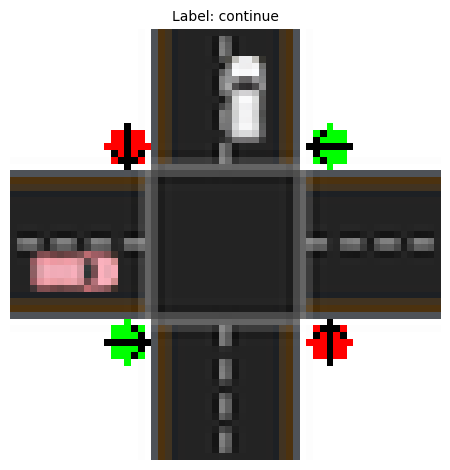

In [31]:
import matplotlib.pyplot as plt

# Select one of those examples for visualization:
selected_sample = x_samples[selected_samples, :, :, :][0]
selected_label = y_samples[selected_samples][0]
label_names = ['stop', 'continue']

# And visualize it
plt.imshow(
    selected_sample.detach().cpu().numpy().transpose(1, 2, 0),
    cmap=None,
)
plt.title(
    f"Label: {label_names[int(selected_label)]}",
    fontsize=10,
)
plt.axis('off')

plt.tight_layout()
plt.show()

In [33]:
model.eval()
emb = encoder(selected_sample.unsqueeze(0))
c_pred = c_layer(emb).sigmoid()
y_pred = y_predictor(c_pred).sigmoid().view(-1)
print(f"Task Prediction: {label_names[(y_pred[0]>0.5)]}")
for idx, concept_name in enumerate(concept_names):
    pred_str = "ON" if c_pred[0, idx] > 0.5 else "OFF"
    print(
        f"\tOur model predicted concept '{concept_name}' to be {pred_str} "
        f"(with prob {c_pred[0, idx]})"
    )

Task Prediction: continue
	Our model predicted concept 'green light on selected lane' to be ON (with prob 0.9999868869781494)
	Our model predicted concept 'car in intersection' to be OFF (with prob 0.04738802835345268)
	Our model predicted concept 'ambulance seen' to be OFF (with prob 8.643821638543159e-05)
	Our model predicted concept 'ambulance approaching perpendicular to selected car' to be OFF (with prob 0.00014905165880918503)


## Step #6: Change concept activations to affect task predictions

In [34]:
# Intervene changing the value of the concepts "ambulance" and
# "ambulance approaching perpendicular to selected car" to True
c_intervened = c_pred[0].clone().unsqueeze(0)
c_intervened[0, 2] = 1 # Ambulance set to True
c_intervened[0, 3] = 1 # Ambulance in perpendicular direction set to True

# Compute new task prediction
y_intervened = y_predictor(c_intervened).sigmoid()

print(f"Task Prediction: {label_names[(y_intervened[0]>0.5)]}")
for idx, concept_name in enumerate(concept_names):
    pred_str = "ON" if c_intervened[0, idx] > 0.5 else "OFF"
    print(
        f"\tOur model predicted concept '{concept_name}' to be {pred_str} "
        f"(with prob {c_intervened[0, idx]})"
    )

Task Prediction: stop
	Our model predicted concept 'green light on selected lane' to be ON (with prob 0.9999868869781494)
	Our model predicted concept 'car in intersection' to be OFF (with prob 0.04738802835345268)
	Our model predicted concept 'ambulance seen' to be ON (with prob 1.0)
	Our model predicted concept 'ambulance approaching perpendicular to selected car' to be ON (with prob 1.0)


In [35]:
# Intervene changing the value of the concepts "ambulance" and
# "ambulance approaching perpendicular to selected car" to False
c_intervened = c_pred[0].clone().unsqueeze(0)
c_intervened[0, 2] = 1 # Ambulance set to True
c_intervened[0, 3] = 0 # Ambulance in perpendicular direction set to False

# Compute new task prediction
y_intervened = y_predictor(c_intervened).sigmoid()

print(f"Task Prediction: {label_names[(y_intervened[0]>0.5)]}")
for idx, concept_name in enumerate(concept_names):
    pred_str = "ON" if c_intervened[0, idx] > 0.5 else "OFF"
    print(
        f"\tOur model predicted concept '{concept_name}' to be {pred_str} "
        f"(with prob {c_intervened[0, idx]})"
    )

Task Prediction: continue
	Our model predicted concept 'green light on selected lane' to be ON (with prob 0.9999868869781494)
	Our model predicted concept 'car in intersection' to be OFF (with prob 0.04738802835345268)
	Our model predicted concept 'ambulance seen' to be ON (with prob 1.0)
	Our model predicted concept 'ambulance approaching perpendicular to selected car' to be OFF (with prob 0.0)
